## Load data

In [1]:
from dataAnalysis.DataAnalysis import DataAnalysis
import pandas as pd

data = pd.read_csv(r"extdata/sbcdata.csv", header=0)
mimic_data = pd.read_csv(r"mimic_cbc.csv", header=0)
data_analysis = DataAnalysis(data, mimic_data)

/home/dwalke/git/sbc/dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']
/home/dwalke/git/sbc/dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']


Training: 
Assessable data are 528101 cases and 1015074 CBCs
Control data are 527038 cases and 1013548 CBCs
Sepsis data are 1488 cases and 1526 CBCs
$$$$$$$$$$$$$$$$$$$$
Testing: 


/home/dwalke/git/sbc/dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']


Controls: 365794, Sepsis: 490
Assessable data are 180494 cases and 366284 CBCs
Control data are 180157 cases and 365794 CBCs
Sepsis data are 472 cases and 490 CBCs


/home/dwalke/git/sbc/dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']


Controls: 437629, Sepsis: 448
Assessable data are 157922 cases and 438077 CBCs
Control data are 180157 cases and 437629 CBCs
Sepsis data are 438 cases and 448 CBCs


In [6]:
import torch

y_train = torch.tensor(data_analysis.get_y_train(), dtype=torch.long)
X_train = torch.tensor(data_analysis.get_X_train(), dtype=torch.float)

y_test = torch.tensor(data_analysis.get_y_test(), dtype=torch.long)
X_test = torch.tensor(data_analysis.get_X_test(), dtype=torch.float)

y_gw_test = torch.tensor(data_analysis.get_y_gw(), dtype=torch.long)
X_gw_test = torch.tensor(data_analysis.get_X_gw(), dtype=torch.float)

X_mimic = torch.tensor(data_analysis.get_X_mimic(), dtype=torch.float)
y_mimic = torch.tensor(data_analysis.get_y_mimic(), dtype= torch.long)

## Concatenate and normalize data

In [7]:
y_all = torch.concat((y_train, y_test, y_gw_test))
X_all = torch.concat((X_train, X_test, X_gw_test))

In [8]:
def normalize(tensor):
    mean = torch.mean(tensor, dim = 0)
    std = torch.std(tensor, dim = 0)
    mean_diff = tensor - mean
    return mean_diff / std

X_all = normalize(X_all)
X_mimic = normalize(X_mimic)

## Random Undersample data for clearer visualization

In [9]:
from imblearn.under_sampling import RandomUnderSampler as RUS
rus = RUS(random_state=42)
X_res, y_res = rus.fit_resample(X_all, y_all)
X_res_mimic, y_res_mimic = rus.fit_resample(X_mimic, y_mimic)

## PCA Biplot

<Figure size 640x480 with 0 Axes>

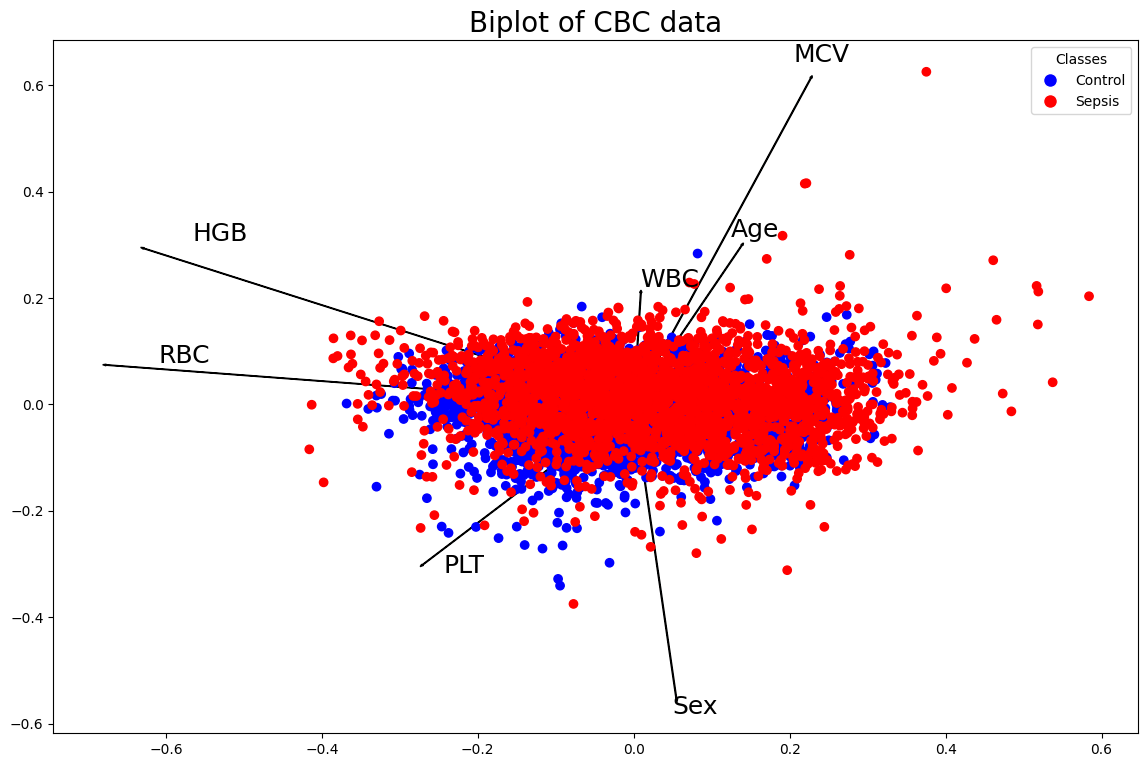

<Figure size 640x480 with 0 Axes>

In [7]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from dataAnalysis.Constants import FEATURES, SEX_CATEGORY_COLUMN_NAME
from sklearn.decomposition import PCA

##https://statisticsglobe.com/biplot-pca-python
scaler = StandardScaler()
 
scaler.fit(X_res)
 
scaled_data = scaler.transform(X_res)

pca = PCA(n_components=2)
PC1 = pca.fit_transform(scaled_data)[:,0]
PC2 = pca.fit_transform(scaled_data)[:,1]
ldngs = pca.components_

scalePC1 = 1.0/(PC1.max() - PC1.min())
scalePC2 = 1.0/(PC2.max() - PC2.min())
features = FEATURES

fig, ax = plt.subplots(figsize=(14, 9))
 
for i, feature in enumerate(features):
    ax.arrow(0, 0, ldngs[0, i], 
             ldngs[1, i])
    ax.text(ldngs[0, i] * 0.9, 
            ldngs[1, i] * 1.05, 
            feature if feature != SEX_CATEGORY_COLUMN_NAME else "Sex", fontsize=18)
 

colors = ["red" if label else "blue" for label in y_res]
scatter = plt.scatter(PC1 * scalePC1,PC2 * scalePC2, color = colors, label= ["Control", "Sepsis"])

class_colors= {"Control":"blue", "Sepsis":"red"}
# Create custom legend handles and labels
legend_handles = []
legend_labels = []
for class_label, color in class_colors.items():
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10))
    legend_labels.append(class_label)

# Create a legend with the custom handles and labels
plt.legend(legend_handles, legend_labels, title='Classes')

ax.set_title('Biplot of CBC data', fontsize=20)
plt.figure()

## 3D biplot for RUS sbc data

In [9]:
from plotly.offline import plot
import plotly.graph_objs as go
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from dataAnalysis.Constants import FEATURES, SEX_CATEGORY_COLUMN_NAME
from sklearn.decomposition import PCA
import numpy as np
scaler = StandardScaler()
 
scaler.fit(X_res)
 
scaled_data = scaler.transform(X_res)

pca = PCA(n_components=3).fit(scaled_data)

# Get the variance of each component
variance = pca.explained_variance_ratio_

# Print the variance of each component
for i, var in enumerate(variance):
    print(f"Variance of Component {i+1}: {var}")
    
X_reduced = pca.transform(scaled_data)

X_reduced_control = X_reduced[np.asarray(y_res) == 0]
trace_control = go.Scatter3d(
    x=X_reduced_control[:,0],
    y = X_reduced_control[:,1],
    z = X_reduced_control[:,2],
    mode='markers',
    marker=dict(
        size=4,               
        opacity=1,
        color=["blue" for i in y_res]
),name="Control"
)
X_reduced_sepsis = X_reduced[np.asarray(y_res) == 1]
trace_sepsis = go.Scatter3d(
    x=X_reduced_sepsis[:,0],
    y = X_reduced_sepsis[:,1],
    z = X_reduced_sepsis[:,2],
    mode='markers',
    marker=dict(
        size=4,               
        opacity=1,
        color=["red" for i in y_res]
),
    name="Sepsis"
)
data = [trace_control, trace_sepsis]
colors= ["red", "blue", "yellow", "green", "black", "cyan", "pink"]
for i, feature in enumerate(FEATURES):
    SCALED_LINE = 10
    dc = go.Scatter3d( x = [0,pca.components_.T[i][0] * SCALED_LINE],
                         y = [0,pca.components_.T[i][1] * SCALED_LINE],
                         z = [0,pca.components_.T[i][2] * SCALED_LINE],
                         marker = dict( size = 1),
                         line = dict( color = colors[i],
                                    width = 10),
                         name = feature if feature is not SEX_CATEGORY_COLUMN_NAME else "Sex"
                         )
    data.append(dc)


layout = go.Layout(
    xaxis=dict(
        title='PC1',
        titlefont=dict(
           family='Courier New, monospace',
           size=18,
           color='#7f7f7f'
       )
   )
)
fig = go.Figure(data=data, layout=layout)
plot(fig, filename='3d-scatter')

Variance of Component 1: 0.29652148485183716
Variance of Component 2: 0.17175762355327606
Variance of Component 3: 0.15945076942443848


/home/dwalke/.local/lib/python3.10/site-packages/plotly/offline/offline.py:562: UserWarning:

Your filename `3d-scatter` didn't end with .html. Adding .html to the end of your file.



'3d-scatter.html'

## 3D biplot for RUS mimic data

In [12]:
from plotly.offline import plot
import plotly.graph_objs as go
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from dataAnalysis.Constants import FEATURES, SEX_CATEGORY_COLUMN_NAME
from sklearn.decomposition import PCA
import numpy as np

scaler = StandardScaler()
 
scaler.fit(X_res_mimic)
 
scaled_data = scaler.transform(X_res_mimic)

pca = PCA(n_components=3).fit(scaled_data)

# Get the variance of each component
variance = pca.explained_variance_ratio_

# Print the variance of each component
for i, var in enumerate(variance):
    print(f"Variance of Component {i+1}: {var}")
    
X_reduced = pca.transform(scaled_data)

X_reduced_control = X_reduced[np.asarray(y_res_mimic) == 0]
trace_control = go.Scatter3d(
    x=X_reduced_control[:,0],
    y = X_reduced_control[:,1],
    z = X_reduced_control[:,2],
    mode='markers',
    marker=dict(
        size=4,               
        opacity=1,
        color=["blue" for i in y_res]
),name="Control"
)
X_reduced_sepsis = X_reduced[np.asarray(y_res_mimic) == 1]
trace_sepsis = go.Scatter3d(
    x=X_reduced_sepsis[:,0],
    y = X_reduced_sepsis[:,1],
    z = X_reduced_sepsis[:,2],
    mode='markers',
    marker=dict(
        size=4,               
        opacity=1,
        color=["red" for i in y_res_mimic]
),
    name="Sepsis"
)
data = [trace_control, trace_sepsis]
colors= ["red", "blue", "yellow", "green", "black", "cyan", "pink"]
for i, feature in enumerate(FEATURES):
    SCALED_LINE = 10
    dc = go.Scatter3d( x = [0,pca.components_.T[i][0] * SCALED_LINE],
                         y = [0,pca.components_.T[i][1] * SCALED_LINE],
                         z = [0,pca.components_.T[i][2] * SCALED_LINE],
                         marker = dict( size = 1),
                         line = dict( color = colors[i],
                                    width = 10),
                         name = feature if feature is not SEX_CATEGORY_COLUMN_NAME else "Sex"
                         )
    data.append(dc)


layout = go.Layout(
    xaxis=dict(
        title='PC1',
        titlefont=dict(
           family='Courier New, monospace',
           size=18,
           color='#7f7f7f'
       )
   )
)
fig = go.Figure(data=data, layout=layout)
plot(fig, filename='3d-scatter_mimic')

Variance of Component 1: 0.3006378412246704
Variance of Component 2: 0.17780794203281403
Variance of Component 3: 0.16205725073814392


/home/dwalke/.local/lib/python3.10/site-packages/plotly/offline/offline.py:562: UserWarning:

Your filename `3d-scatter_mimic` didn't end with .html. Adding .html to the end of your file.



'3d-scatter_mimic.html'